In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import numpy as np

In [2]:
def process_one_file(filename):
    with open(filename, 'r') as f:
        results = json.load(f)
    patients = [int(x.split('_')[0]) for x in results.keys()]
    sup_results_acc = list()
    sup_results_kappa = list()
    log_results_acc = list()
    log_results_kappa = list()
    fine_results_acc = list()
    fine_results_kappa = list()
    for value in results.values():
        sup_results_acc.append(np.mean([value['sup_res'][i][0]['test_acc'] for i in range(len(value['sup_res']))]))
        sup_results_kappa.append(np.mean([value['sup_res'][i][0]['kappa'] for i in range(len(value['sup_res']))]))
        log_results_acc.append(np.mean([value['logistic_res'][i][0]['test_acc'] for i in range(len(value['logistic_res']))]))
        log_results_kappa.append(np.mean([value['logistic_res'][i][0]['kappa'] for i in range(len(value['logistic_res']))]))
        fine_results_acc.append(np.mean([value['fully_tuned_res'][i][0]['test_acc'] for i in range(len(value['fully_tuned_res']))]))
        fine_results_kappa.append(np.mean([value['fully_tuned_res'][i][0]['kappa'] for i in range(len(value['fully_tuned_res']))]))
    return {
        'patients': patients,
        'sup_results_acc': sup_results_acc,
        'sup_results_kappa': sup_results_kappa,
        'log_results_acc': log_results_acc,
        'log_results_kappa': log_results_kappa,
        'fine_results_acc': fine_results_acc,
        'fine_results_kappa': fine_results_kappa
    }

In [3]:
def plot_simclr(patients, sup_results, log_results, fine_results, ylabel="Test accuracy", save_name=None, sup_std=None, log_std=None, fine_std=None):
    fig = plt.figure(figsize=(12,8))
    plt.plot(patients, sup_results, '--', color="darkblue", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=14, label="Fully supervised (no pretraining)")
    if sup_std is not None:
        plt.fill_between(patients, sup_results + sup_std, sup_results-sup_std, color="skyblue")
    plt.plot(patients, log_results, '--', color="darkred", marker="^", markeredgecolor="#000", markerfacecolor="y", markersize=14, label="Frozen pretrained backbone")
    if log_std is not None:
        plt.fill_between(patients, log_results + log_std, log_results-log_std, color="indianred")
    plt.plot(patients, fine_results, '--', color="forestgreen", marker="o", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fully supervised fine-tuning")
    if fine_std is not None:
        plt.fill_between(patients, fine_results + fine_std, fine_results-fine_std, color="limegreen")
    plt.xscale("log")
    plt.xticks(patients, labels=patients)
    plt.title("SimCLR results, pretrained on 3000 patients")
    plt.xlabel("Number of labeled patients used")
    plt.ylabel(ylabel + " on test set")
    plt.minorticks_off()
    plt.legend()
    #plt.legend(["Fully supervised (no pretraining)", "Frozen pretrained backbone", "Fine-tuned backbone"])
    if save_name is not None:
        plt.savefig(save_name, facecolor="white")
    plt.show()

In [4]:
sample_results = process_one_file('sample_results')
plot_simclr(sample_results['patients'], sample_results['sup_results_acc'], sample_results['log_results_acc'], sample_results['fine_results_acc'])

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [4]:
def process_multiple_files(filenames):
    """
        To process multiple files, they must contain the same data structure
    """
    patients = process_one_file(filenames[0])['patients']
    n_patients = len(patients)
    n_files = len(filenames)
    n_metrics = 6
    all_results = np.ndarray((n_files, n_metrics, n_patients))
    for i, filename in enumerate(filenames):
        file_results = process_one_file(filename)
        all_results[i, :, :] = list(file_results.values())[1:]
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)
    return {
        'patients': patients,
        'sup_results_acc': {'mean': mean_results[0,:], 'std': std_results[0,:]},
        'sup_results_kappa': {'mean': mean_results[1,:], 'std': std_results[1,:]},
        'log_results_acc': {'mean': mean_results[2,:], 'std': std_results[2,:]},
        'log_results_kappa': {'mean': mean_results[3,:], 'std': std_results[3,:]},
        'fine_results_acc': {'mean': mean_results[4,:], 'std': std_results[4,:]},
        'fine_results_kappa': {'mean': mean_results[5,:], 'std': std_results[5,:]},
    }

In [47]:
all_results_transformer = process_multiple_files([
    'CnnTransformer\\simclr\\test_results\\test_results_cnn_transformer35',
    'CnnTransformer\\simclr\\test_results\\test_results_cnn_transformer36',
    'CnnTransformer\\simclr\\test_results\\test_results_cnn_transformer37',
    'CnnTransformer\\simclr\\test_results\\test_results_cnn_transformer38',
    'CnnTransformer\\simclr\\test_results\\test_results_cnn_transformer39',
])

In [52]:
all_results_cnn = process_multiple_files([
    'CnnEncoder\\simclr\\test_results\\test_results_cnn_encoder_final30',
    'CnnEncoder\\simclr\\test_results\\test_results_cnn_encoder_final32',
    'CnnEncoder\\simclr\\test_results\\test_results_cnn_encoder_final33',
    'CnnEncoder\\simclr\\test_results\\test_results_cnn_encoder_final34'
])
#all_results['sup_results_acc']['mean']

In [7]:
all_results = process_multiple_files([
    'sample_results',
    'sample_results2'
])

In [49]:
all_results = all_results_transformer

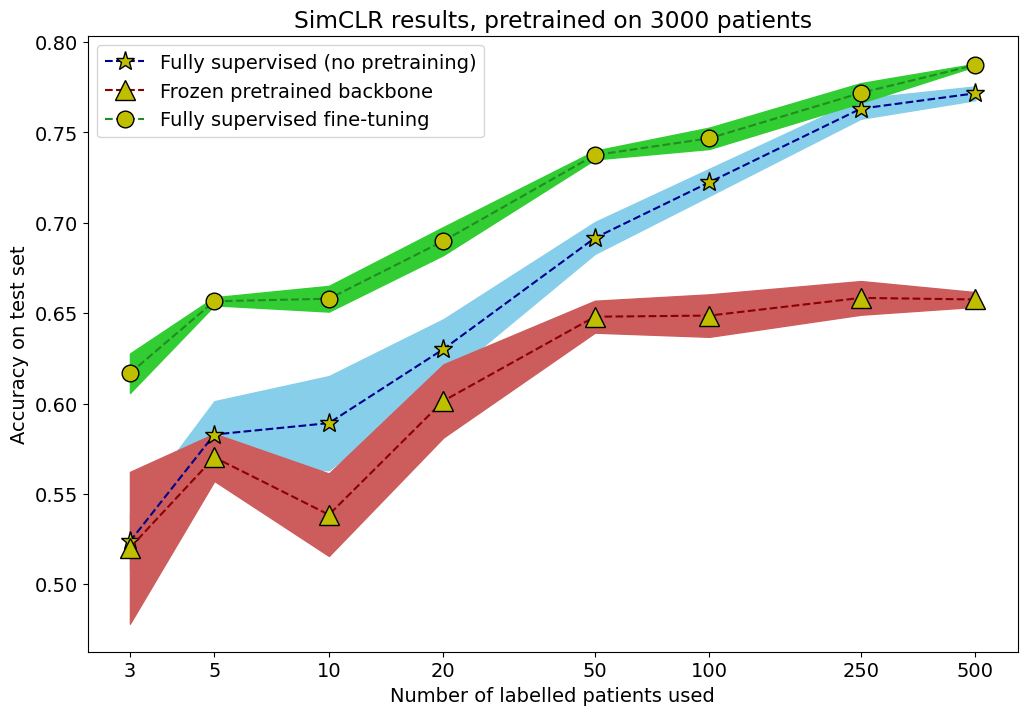

In [50]:
# Plot acc
plot_simclr(all_results['patients'], all_results['sup_results_acc']['mean'], all_results['log_results_acc']['mean'], all_results['fine_results_acc']['mean'],
            ylabel='Accuracy', sup_std=all_results['sup_results_acc']['std'], log_std=all_results['log_results_acc']['std'], fine_std=all_results['fine_results_acc']['std'],
            save_name="final_cnn_transformer_graph_acc")

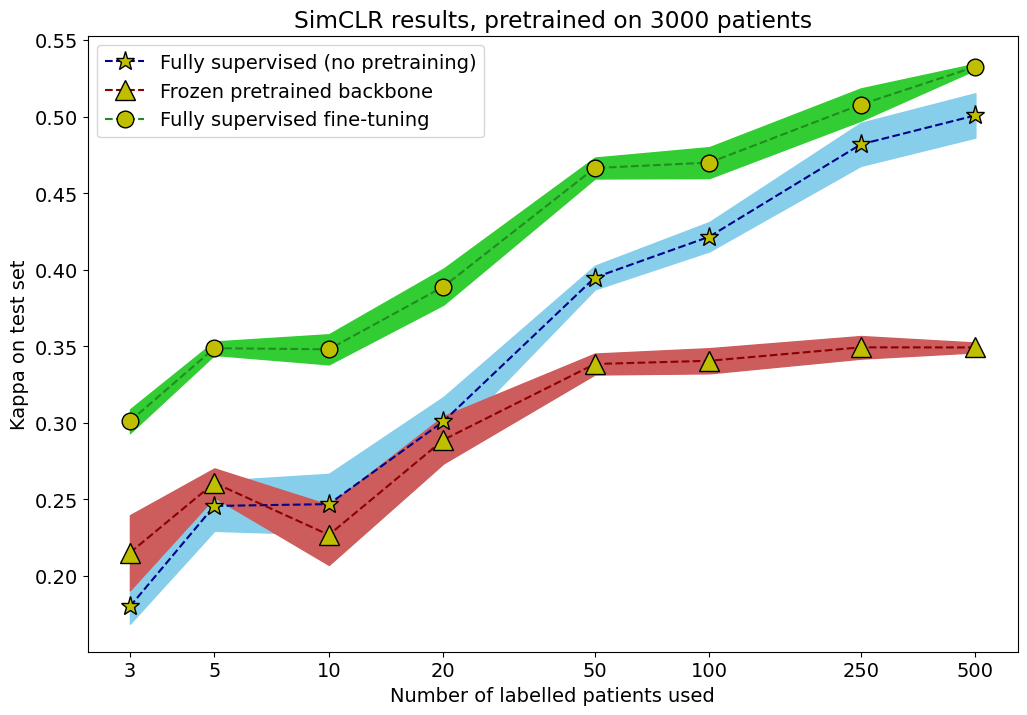

In [51]:
# Plot kappa
plot_simclr(all_results['patients'], all_results['sup_results_kappa']['mean'], all_results['log_results_kappa']['mean'], all_results['fine_results_kappa']['mean'],
            ylabel='Kappa', sup_std=all_results['sup_results_kappa']['std'], log_std=all_results['log_results_kappa']['std'], fine_std=all_results['fine_results_kappa']['std'],
            save_name="final_cnn_transformer_graph_kappa")

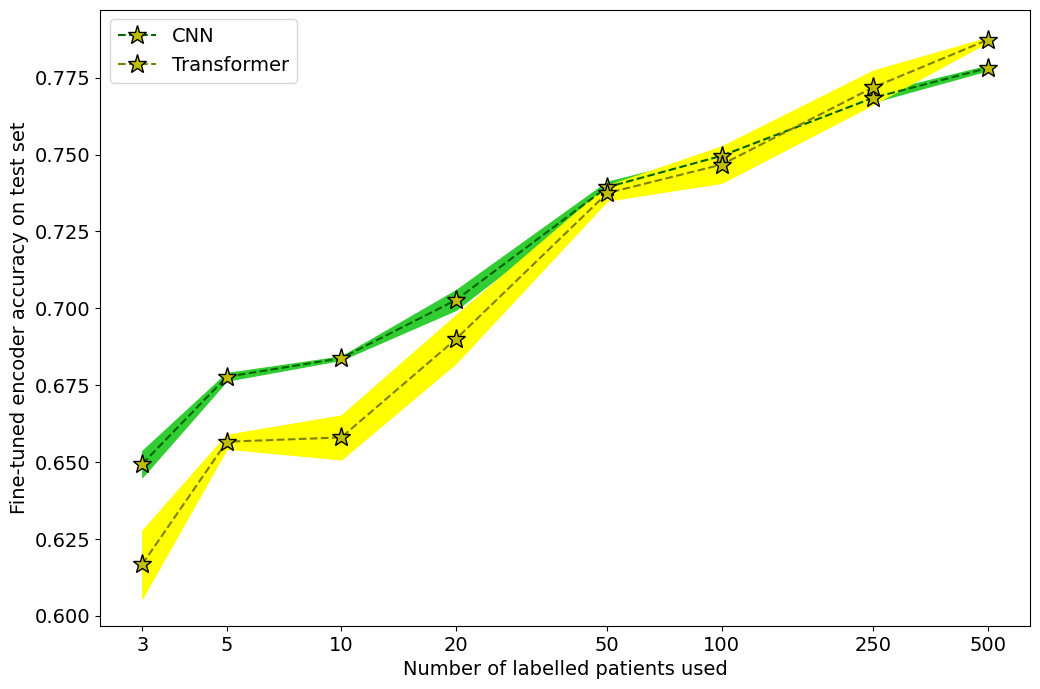

In [59]:
def compare(patients, results_cnn, results_transformer, metric, save_name=None):
    fig = plt.figure(figsize=(12,8))

    results_cnn_mean = results_cnn[metric]['mean']
    results_cnn_std = results_cnn[metric]['std']
    results_transformer_mean = results_transformer[metric]['mean']
    results_transformer_std = results_transformer[metric]['std']

    plt.plot(patients, results_cnn_mean, '--', color="darkgreen", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=14, label="CNN")
    plt.fill_between(patients, results_cnn_mean + results_cnn_std, results_cnn_mean-results_cnn_std, color="limegreen")

    plt.plot(patients, results_transformer_mean, '--', color="olive", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=14, label="Transformer")
    plt.fill_between(patients, results_transformer_mean + results_transformer_std, results_transformer_mean-results_transformer_std, color="yellow")

    plt.xscale("log")
    plt.xticks(patients, labels=patients)
    plt.xlabel("Number of labeled patients used")
    plt.ylabel('Fine-tuned encoder accuracy on test set')
    plt.minorticks_off()
    plt.legend()
    #plt.legend(["Fully supervised (no pretraining)", "Frozen pretrained backbone", "Fine-tuned backbone"])
    if save_name is not None:
        plt.savefig(save_name, facecolor="white")
    plt.show()
compare(patients=all_results_cnn['patients'], results_cnn=all_results_cnn, results_transformer=all_results_transformer, metric='fine_results_acc', save_name='comparison')

# Process outer results

In [5]:
def process_one_file_outer(filename):
    with open(filename, 'r') as f:
        value = json.load(f)
    no_pre_results_acc = np.mean([value['no_pretrain_res'][i][0]['test_acc'] for i in range(len(value['no_pretrain_res']))])
    no_pre_results_kappa = np.mean([value['no_pretrain_res'][i][0]['kappa'] for i in range(len(value['no_pretrain_res']))])
    sup_results_acc = np.mean([value['sup_res'][i][0]['test_acc'] for i in range(len(value['sup_res']))])
    sup_results_kappa = np.mean([value['sup_res'][i][0]['kappa'] for i in range(len(value['sup_res']))])
    sup_results_fine_acc = np.mean([value['sup_res_fine'][i][0]['test_acc'] for i in range(len(value['sup_res']))])
    sup_results_fine_kappa = np.mean([value['sup_res_fine'][i][0]['kappa'] for i in range(len(value['sup_res']))])


    log_results_acc = np.mean([value['logistic_res'][i][0]['test_acc'] for i in range(len(value['logistic_res']))])
    log_results_kappa = np.mean([value['logistic_res'][i][0]['kappa'] for i in range(len(value['logistic_res']))])
    intermediate_results_acc = np.mean([value['intermediate_res'][i][0]['test_acc'] for i in range(len(value['intermediate_res']))])
    intermediate_results_kappa = np.mean([value['intermediate_res'][i][0]['kappa'] for i in range(len(value['intermediate_res']))])
    fine_results_acc = np.mean([value['fully_tuned_res'][i][0]['test_acc'] for i in range(len(value['fully_tuned_res']))])
    fine_results_kappa = np.mean([value['fully_tuned_res'][i][0]['kappa'] for i in range(len(value['fully_tuned_res']))])
    return {
        'no_pre_results_acc': no_pre_results_acc,
        'no_pre_results_kappa': no_pre_results_kappa,
        'sup_results_acc': sup_results_acc,
        'sup_results_kappa': sup_results_kappa,
        'sup_results_fine_acc': sup_results_fine_acc,
        'sup_results_fine_kappa': sup_results_fine_kappa,
        'log_results_acc': log_results_acc,
        'log_results_kappa': log_results_kappa,
        'intermediate_results_acc': intermediate_results_acc,
        'intermediate_results_kappa': intermediate_results_kappa,
        'fine_results_acc': fine_results_acc,
        'fine_results_kappa': fine_results_kappa
    }

In [22]:
def plot_randomshuffle(patients, log_results, intermediate_results, fine_results, no_pretrain_results, sup_results, sup_fine_results, ylabel="Test accuracy", save_name=None, sup_std=None, log_std=None, fine_std=None):
    fig = plt.figure(figsize=(12,8))
    #plt.plot(patients, log_results, '--', color="darkblue", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fro pre enc, Fro pre trans")
    #plt.plot(patients, intermediate_results, '--', color="darkred", marker="o", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fro pre enc, Fine pre trans")
    #plt.plot(patients, fine_results, '--', color="darkgreen", marker="v", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fine pre enc, Fine pre trans")
    #plt.plot(patients, no_pretrain_results, '--', color="black", marker="x", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fine ran enc, Fine ran trans")
    #plt.plot(patients, sup_results, '--', color="orange", marker="+", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fro pre enc, Fine ran trans")
    #plt.plot(patients, sup_fine_results, '--', color="magenta", marker="s", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Fine pre enc, Fine ran trans")

    plt.plot(patients, no_pretrain_results, '--', color="black", marker="x", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Random encoder weights, random transformer weights")
    plt.plot(patients, sup_fine_results, '--', color="magenta", marker="s", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Pretrained encoder weights, random transformer weights")
    plt.plot(patients, intermediate_results, '--', color="darkred", marker="o", markeredgecolor="#000", markerfacecolor="y", markersize=12, label="Pretrained encoder weights + pretrained transformer weights")

    plt.xscale("log")
    plt.xticks(patients, labels=patients)
    plt.title("Pretext task results, pretrained on 3000 patients")
    plt.xlabel("Number of labeled patients used")
    plt.ylabel(ylabel + " on test set")
    plt.minorticks_off()
    plt.legend()
    #plt.legend(["Fully supervised (no pretraining)", "Frozen pretrained backbone", "Fine-tuned backbone"])
    if save_name is not None:
        plt.savefig(save_name, facecolor="white")
    plt.show()

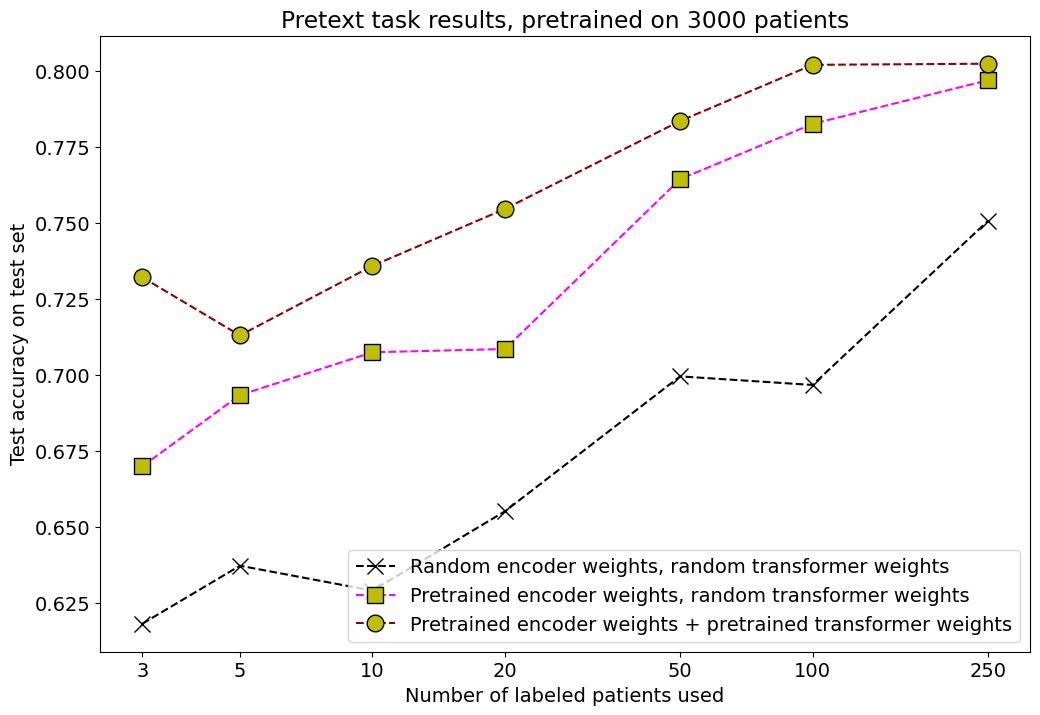

In [29]:
patients_outer = [3, 5, 10, 20, 50, 100, 250]
results = list()
result_files = ['RandomShuffleTransformer\\results_randomshuffle\\test_on_' + str(i) + 'pat' for i in patients_outer]

no_pretrain_acc = list()
no_pretrain_kappa = list()
sup_results_acc = list()
sup_results_kappa = list()
sup_results_fine_acc = list()
sup_results_fine_kappa = list()

log_results_acc = list()
log_results_kappa = list()
intermediate_results_acc = list()
intermediate_results_kappa = list()
fine_results_acc = list()
fine_results_kappa = list()

for result_path in result_files:
    result = process_one_file_outer(result_path)
    no_pretrain_acc.append(result['no_pre_results_acc'])
    no_pretrain_kappa.append(result['no_pre_results_kappa'])
    sup_results_acc.append(result['sup_results_acc'])
    sup_results_kappa.append(result['sup_results_kappa'])
    sup_results_fine_acc.append(result['sup_results_fine_acc'])
    sup_results_fine_kappa.append(result['sup_results_fine_kappa'])
    log_results_acc.append(result['log_results_acc'])
    log_results_kappa.append(result['log_results_kappa'])
    intermediate_results_acc.append(result['intermediate_results_acc'])
    intermediate_results_kappa.append(result['intermediate_results_kappa'])
    fine_results_acc.append(result['fine_results_acc'])
    fine_results_kappa.append(result['fine_results_kappa'])

plot_randomshuffle(patients_outer,
                   log_results=log_results_acc,
                   intermediate_results=intermediate_results_acc,
                   fine_results=fine_results_acc,
                   no_pretrain_results=no_pretrain_acc,
                   sup_results=sup_results_acc,
                   sup_fine_results=sup_results_fine_acc,
                   save_name='pretext_task_results'
                   )

# Plot training curves of pretraining

In [26]:
import pandas as pd
time_epoch = pd.read_csv('RandomShuffleTransformer/results_randomshuffle/pretext_100pat_time.csv')
acc_epoch5 = pd.read_csv('RandomShuffleTransformer/results_randomshuffle/pretext_100pat_trainacc.csv')
acc_epoch1 = pd.read_csv('RandomShuffleTransformer/results_randomshuffle/pretext_100pat_valacc.csv')
time_epoch = time_epoch.rename(columns={'Value': 'Epoch'})
acc_epoch5 = acc_epoch5.rename(columns={'Value': 'ValAcc5'})
acc_epoch1 = acc_epoch1.rename(columns={'Value': 'ValAcc1'})
merged_df = pd.merge(acc_epoch1, time_epoch, on="Step")
merged_df = pd.merge(merged_df, acc_epoch5, on="Step")

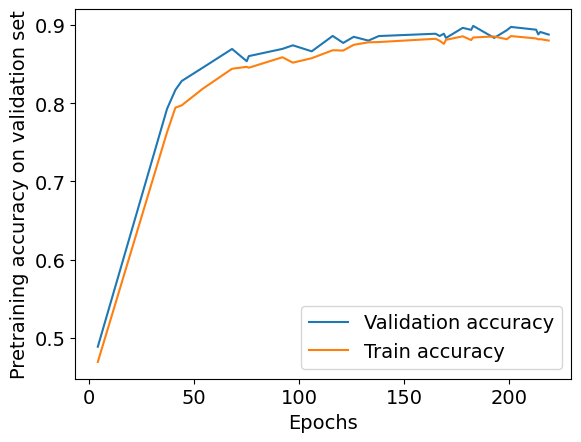

In [28]:
plt.plot(merged_df['Epoch'], merged_df['ValAcc1'], label="Validation accuracy")
plt.plot(merged_df['Epoch'], merged_df['ValAcc5'], label="Train accuracy")
plt.xlabel('Epochs')
plt.ylabel('Pretraining accuracy on validation set')
plt.legend()
plt.savefig('pretext_task_train_val', facecolor="white")
plt.show()

,Wall time_x,Step,Value,Wall time_y,Epoch
0,1.684492e+09,260,0.425962,1.684492e+09,0.0
1,1.684492e+09,505,0.537029,1.684492e+09,1.0
2,1.684492e+09,753,0.637601,1.684492e+09,2.0
3,1.684492e+09,1018,0.735218,1.684492e+09,3.0
4,1.684493e+09,1250,0.771282,1.684493e+09,4.0
...,...,...,...,...,...
135,1.684530e+09,35007,0.947173,1.684530e+09,135.0
136,1.684530e+09,35253,0.963067,1.684530e+09,136.0
137,1.684531e+09,35615,0.954210,1.684531e+09,137.0
138,1.684531e+09,35876,0.931776,1.684531e+09,138.0


In [17]:
acc_epoch

,Wall time,Step,Value
0,1.684492e+09,260,0.425962
1,1.684492e+09,505,0.537029
2,1.684492e+09,753,0.637601
3,1.684492e+09,1018,0.735218
4,1.684493e+09,1250,0.771282
...,...,...,...
135,1.684530e+09,35007,0.947173
136,1.684530e+09,35253,0.963067
137,1.684531e+09,35615,0.954210
138,1.684531e+09,35876,0.931776
